# Init

In [2]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import os
import h5py
import sys 
plt.style.use('/Users/daniel_vander-hyde/Documents/git/my_python/matplotlib/stylelib/pptsize')

def concat_vecs(directory):
    txtcounter = len(glob.glob1(directory,"*.TXT"))
    freq = np.zeros((801,txtcounter))
    freq1 = np.zeros((801,txtcounter))
    vpk = np.zeros((801,txtcounter))

    columns = range(0,txtcounter)
    fff = 0
    vpkn = 0
    ##  import and measurements
    for i in columns: 
        data = np.loadtxt(directory + str(i).zfill(2) + '.TXT')
        freq[:,i] = data[:,0]
        vpk[:,i] = data[:,1]
        if i == columns[0]:
            fff = freq[:,i]
            vpkn = vpk[:,i]
        elif i == columns[-1]:
            fff = np.append(fff,freq[:,i])
            vpkn=np.append(vpkn,vpk[:,i])
        else: 
            fff = np.append(fff, freq[:,i][:-1])
            vpkn = np.append(vpkn, vpk[:,i][:-1])
    return fff, vpkn

def transfer_function(amplitude, phase): 
    return 10**(amplitude/20)* np.exp(1j*(phase/180)*np.pi)

def tf_import(tf_path): 
    db = np.loadtxt(tf_path + 'db.TXT')
    deg = np.loadtxt(tf_path + 'deg.TXT')
    ff = db[:,0]
    return ff, db[:,1], deg[:,1]

def tf_interpolate(new_freq, tf_tuple): 
    new_db = np.interp(new_freq, tf_tuple[0], tf_tuple[1])
    new_deg = np.interp(new_freq, tf_tuple[0], tf_tuple[2])
    return new_freq, new_db, new_deg

def bode_plt(data_path, save_path, lbl, title):
    tot = tf_import(data_path)
    ff = tot[0]
    db = tot[1]
    deg = tot[2]
    
    plt.subplot(211)
    plt.semilogx(ff,db, label = lbl)
    plt.xlim(ff[0], ff[-1])
    plt.ylabel('dB')
    plt.legend()
    plt.title(title)
    plt.subplot(212)
    plt.semilogx(ff,deg, label = lbl)
    plt.xlim(ff[0], ff[-1])
    plt.legend()
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('phase [deg]')
    plt.savefig(save_path + '/' + title + '.png', dpi=300,bbox_inches='tight')
    plt.close()
    

def calibrate_eo(vdata_dir, spectra_type, HVA_dir, OLG_dir, final_dir, labl, plot_saving=False, model=False):
    
    #Make final directory
    new_final_dir = final_dir + '/' + labl
  #  figure_dir = new_final_dir + '/figs'
  #  calib_data_dir = new_final_dir + '/data'
    if os.path.isdir(new_final_dir) == False:
        os.mkdir(new_final_dir)
  #  if os.path.isdir(figure_dir) == False: 
  #      os.mkdir(figure_dir)
  #  if os.path.isdir(calib_data) == False:
  #      os.mkdir(calib_data_dir)
    
    plt.style.use('/Users/daniel_vander-hyde/Documents/git/my_python/matplotlib/stylelib/pptsize')
    spectra = concat_vecs(vdata_dir)
    if plot_saving == True: 
        
        #Spectra plotting
        plt.loglog(spectra[0], spectra[1], label=labl)
        plt.legend()
        plt.xlabel('frequency [Hz]')
        plt.xlim([spectra[0][0],spectra[0][-1]])
        if spectra_type == 'pk': 
            plt.ylabel('$$V_\mathrm{pk}$$')
        elif spectra_type == 'rms':
            plt.ylabel('$$V_\mathrm{rms}$$')
        plt.savefig(new_final_dir + '/v' + spectra_type + '_spectra_' + labl + '.png',dpi=300, bbox_inches='tight')
        plt.close()
        
        #HVA plotting
        bode_plt(HVA_dir, new_final_dir, '.75 total gain', 'HVA')
        
        #OLG plotting
        bode_plt(OLG_dir, new_final_dir , labl, 'OLG' )
        
    #Interpolate to common frequency vector
    HVA = tf_import(HVA_dir)
    OLG = tf_import(OLG_dir)
    HVA_inter = tf_interpolate(spectra[0], HVA)
    OLG_inter = tf_interpolate(spectra[0], OLG)
    
    
    #transfer function
    HVA_tf = transfer_function(HVA_inter[1], HVA_inter[2])
    OLG_tf = transfer_function(OLG_inter[1], OLG_inter[2])
    
    #Laser frequency spectra calibration
    laserV2Hz = 2.0e6
    HzpV = HVA_tf*laserV2Hz
    
    #loop calibration
    CLG = 1/(1-OLG_tf)
    CAL = OLG_tf*CLG
    CALVpHz=CAL/HzpV
    CALHzpV=HzpV/CAL
    
    #Laser frequency spectra
    freq_noise = abs(CALHzpV)*spectra[1]
    
    
    #plot loop calibration
    
    #Laser frequency noise
    if plot_saving == True:
        plt.loglog(spectra[0],freq_noise, label='Frequency comb (FEB1721)',linewidth=3)
        plt.xlim([spectra[0][0], spectra[0][-1]])
        plt.legend()
        plt.xlabel('Frequency [Hz]')
        plt.ylabel('$$\mathrm{Hz}_\mathrm{pk}$$')
        plt.title("Laser frequency noise from measured voltage noise")
        plt.savefig(new_final_dir + '/Hz' + spectra_type + '_spectra_' + labl + '.png', dpi=300, bbox_inches='tight')
        plt.close()
    
    #Cavity parameters
    c = 299792458
    lamb =1.064e-6
    nu = c/lamb
    Lcav = 0.165
    
    #Displacement spect
    displac_spect = freq_noise*Lcav/nu
    
    #Model estimation
    model_freq = 10000
    marty_estimate = 3.8e-16 #mpk/[V*m]
    Efield_strength_estimate = 6350 #[V*m]
    
    #Displacement spectra
    final_fig = plt.loglog(spectra[0],displac_spect,color='m',label=labl, linewidth=3)
    if model == True:
        plt.loglog(model_freq,marty_estimate*Efield_strength_estimate ,'*',color='m', label='Estimated AlGaAs dn/dE effect with $V_\mathrm{electrode}= 300\; V_\mathrm{pk}$ @ 10000 Hz (inside coating)',markersize=20)
    plt.xlim([spectra[0][0], spectra[0][-1]])
    plt.legend()
    plt.xlabel('Frequency [Hz]')
    if spectra_type == 'pk':
        plt.ylabel('Displacement [$\mathrm{m}_\mathrm{pk}$]')
    if spectra_type == 'rms':
        plt.ylabel('Displacement [$\mathrm{m}_\mathrm{rms}$]')
    plt.title("Displacement spectra for AlGaAs Pockels effect measurement")
    plt.savefig(new_final_dir + '/' + labl + '_' + 'displacement_normal_electrodes.png',dpi=300,bbox_inches='tight')
    
    #Store raw / calibrated data along with metadata in data directory
    with h5py.File(new_final_dir + "/data.hdf5", "a") as f:
        
        ##Initialize hdf5 datasets
        
        #Raw data
        raw = f.create_group("raw")
        freq = f.create_dataset("freq", data=spectra[0])                                 ## common frequency vector
        hva_save = f.create_group("raw/hva")                          # where hva data will be saved
        cav_length = f.create_dataset("cav_length", data=Lcav)
        laser_freq = f.create_dataset("laser_freq", data=nu)
        laserPZTresp = f.create_dataset("laserV2Hz", data=laserV2Hz )
        hva_save.attrs['dir'] = HVA_dir
        olg_save = f.create_group("raw/olg")                          # where olg data will be saved
        olg_save.attrs['dir'] = OLG_dir
        vdata_save = f.create_dataset("raw/v_spect", data=spectra[1])                  # where error signal spectra will be saved
        vdata_save.attrs['units'] = spectra_type
        vdata_save.attrs['dir'] = vdata_dir
        hvadb_save = f.create_dataset("raw/hva/db", data=HVA_inter[1])
        hvadeg_save = f.create_dataset("raw/hva/deg", data=HVA_inter[2])
        olgdb_save = f.create_dataset("raw/olg/db", data=OLG_inter[1])
        olgdeg_save = f.create_dataset("raw/olg/deg", data=OLG_inter[2])
        
        
        #Calibrated data
        calibra = f.create_group("calibrated")
        hvatf_save = f.create_dataset("calibrated/hva",data=HVA_tf) 
        olgtf_save = f.create_dataset("calibrated/olg",data=OLG_tf) 
        freqnoise_save = f.create_dataset("calibrated/HzpV",data=freq_noise)
        displacement_spect = f.create_dataset("calibrated/disp_spect",data=displac_spect)
        displacement_spect.attrs['units'] = spectra_type
        f.close()
        
    return final_fig
    

In [3]:
sys.path

['/Users/daniel_vander-hyde/Documents/git/SU/algaas_electrooptic_effect/code',
 '/Users/daniel_vander-hyde/anaconda3/envs/jupy/lib/python37.zip',
 '/Users/daniel_vander-hyde/anaconda3/envs/jupy/lib/python3.7',
 '/Users/daniel_vander-hyde/anaconda3/envs/jupy/lib/python3.7/lib-dynload',
 '',
 '/Users/daniel_vander-hyde/anaconda3/envs/jupy/lib/python3.7/site-packages',
 '/Users/daniel_vander-hyde/anaconda3/envs/jupy/lib/python3.7/site-packages/IPython/extensions',
 '/Users/daniel_vander-hyde/.ipython']

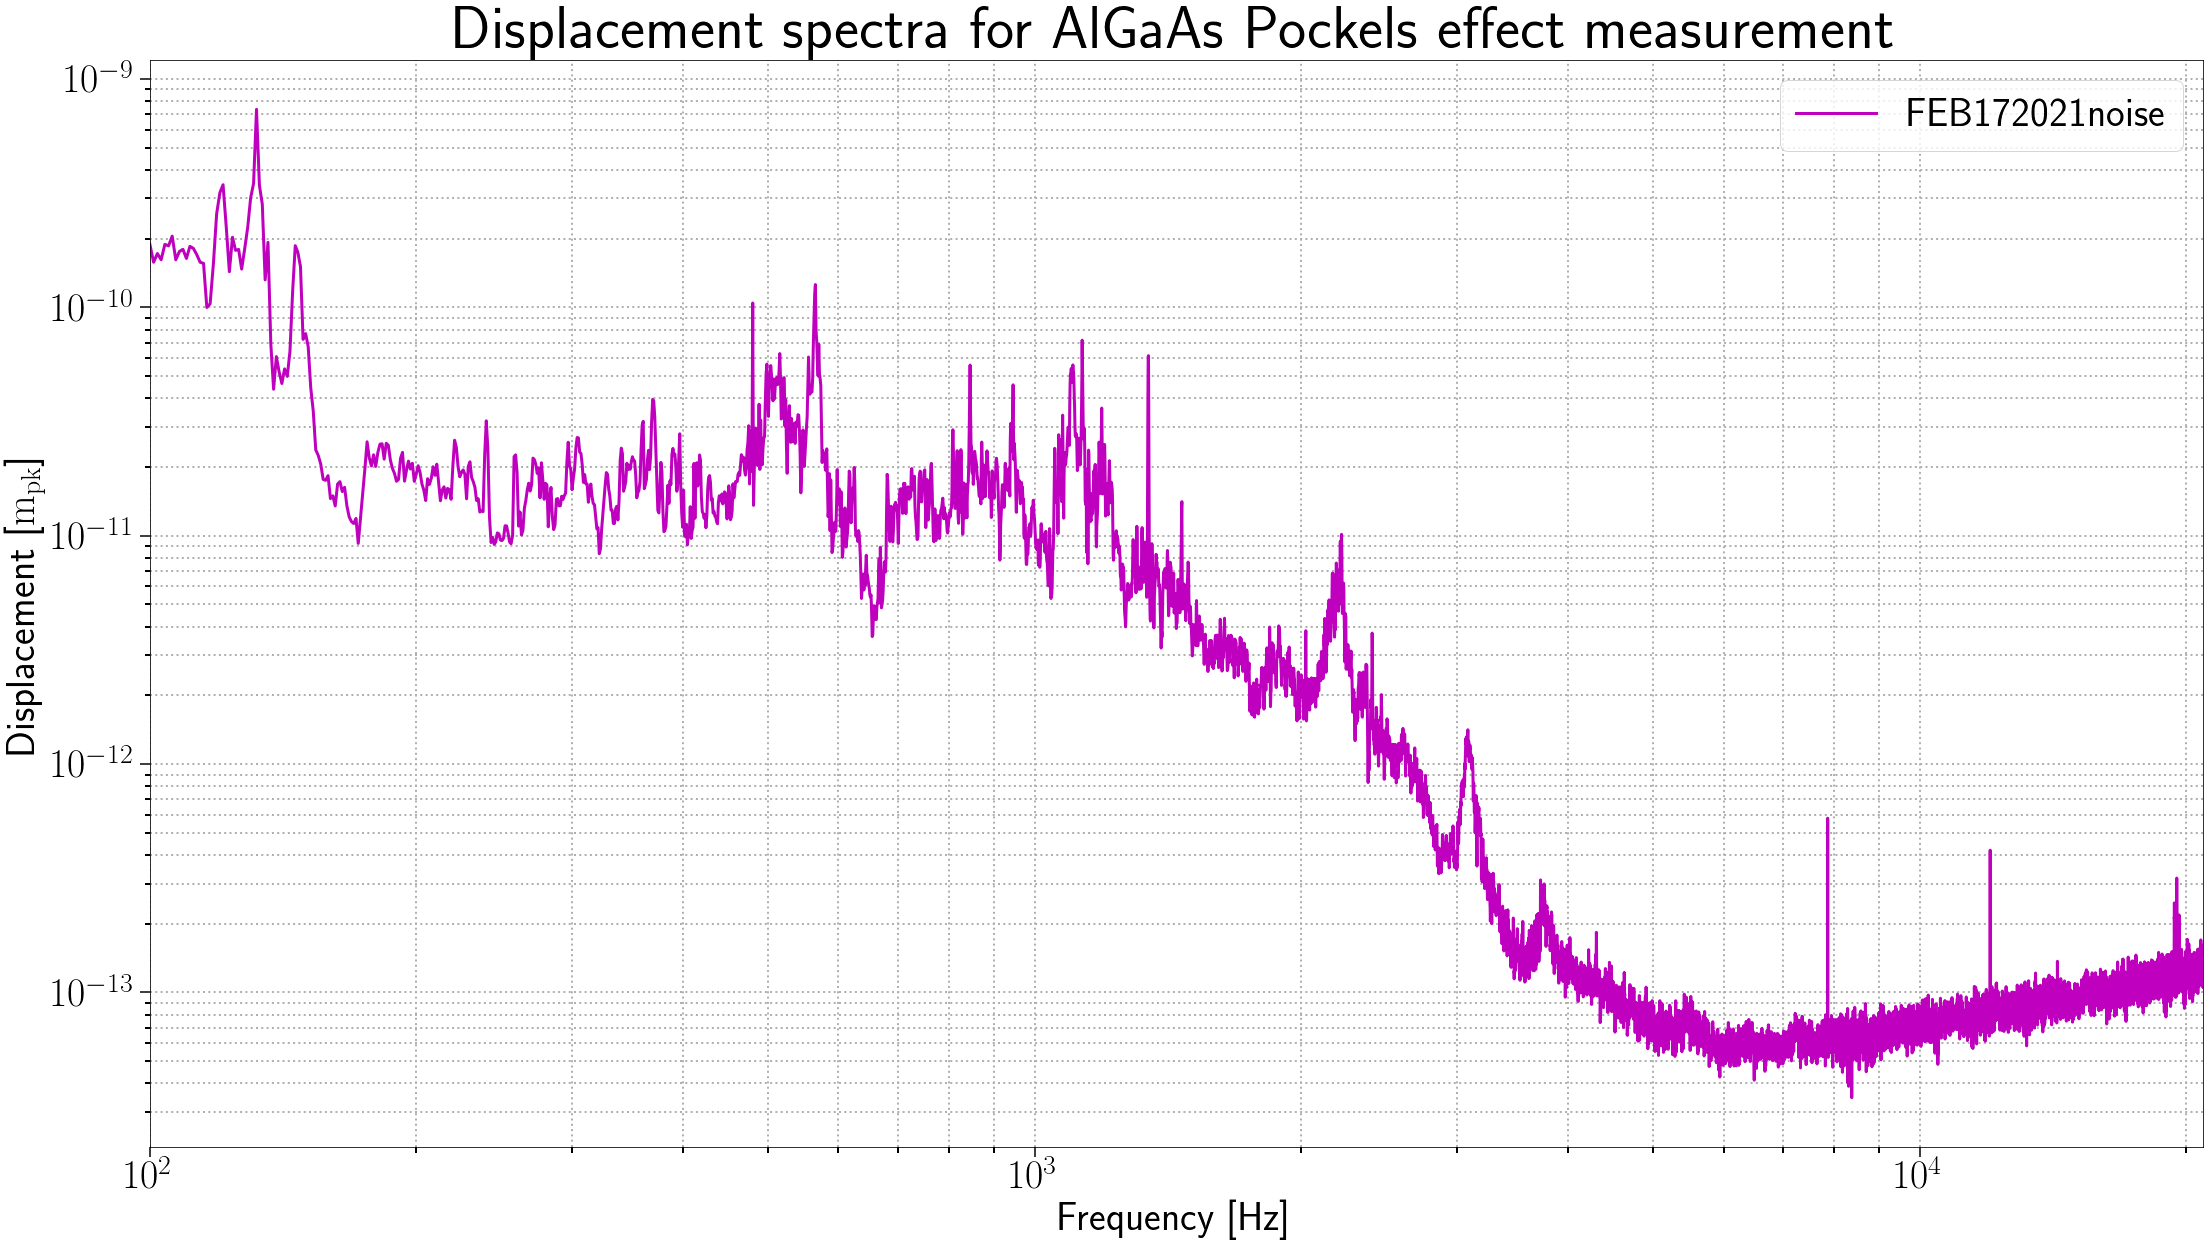

In [186]:
vpksw_dir = common_dir  + h2 + '/' + sample + '/' +  date[3] + '/' + f1 + '/'
OLG_direc = OLG_dir + date[3] + '/'
final_dir = '/Users/daniel_vander-hyde/Documents/git/SU/algaas_electrooptic_effect/results/frequency_comb'
calibrate_eo(vpksw_dir, 'pk', hva2_dir, OLG_direc, final_dir, 'FEB172021noise', plot_saving=True, model=False)

In [187]:
f = h5py.File(final_dir + '/' + 'FEB172021freqcomb' + '/' + 'data.hdf5','r')

In [164]:
def printname(name): 
    print(name)

In [165]:
f.visit(printname)

calibrated
calibrated/HzpV
calibrated/disp_spect
calibrated/hva
calibrated/olg
cav_length
freq
laserV2Hz
laser_freq
raw
raw/hva
raw/hva/db
raw/hva/deg
raw/olg
raw/olg/db
raw/olg/deg
raw/v_spect


In [174]:
f['raw/hva'].attrs['dir']

'/Users/daniel_vander-hyde/Documents/git/SU/algaas_electrooptic_effect/measurements/HVASVR_tf/HVACH3_plus_pomona/02_17_2021/'

(100.0, 20900.0)

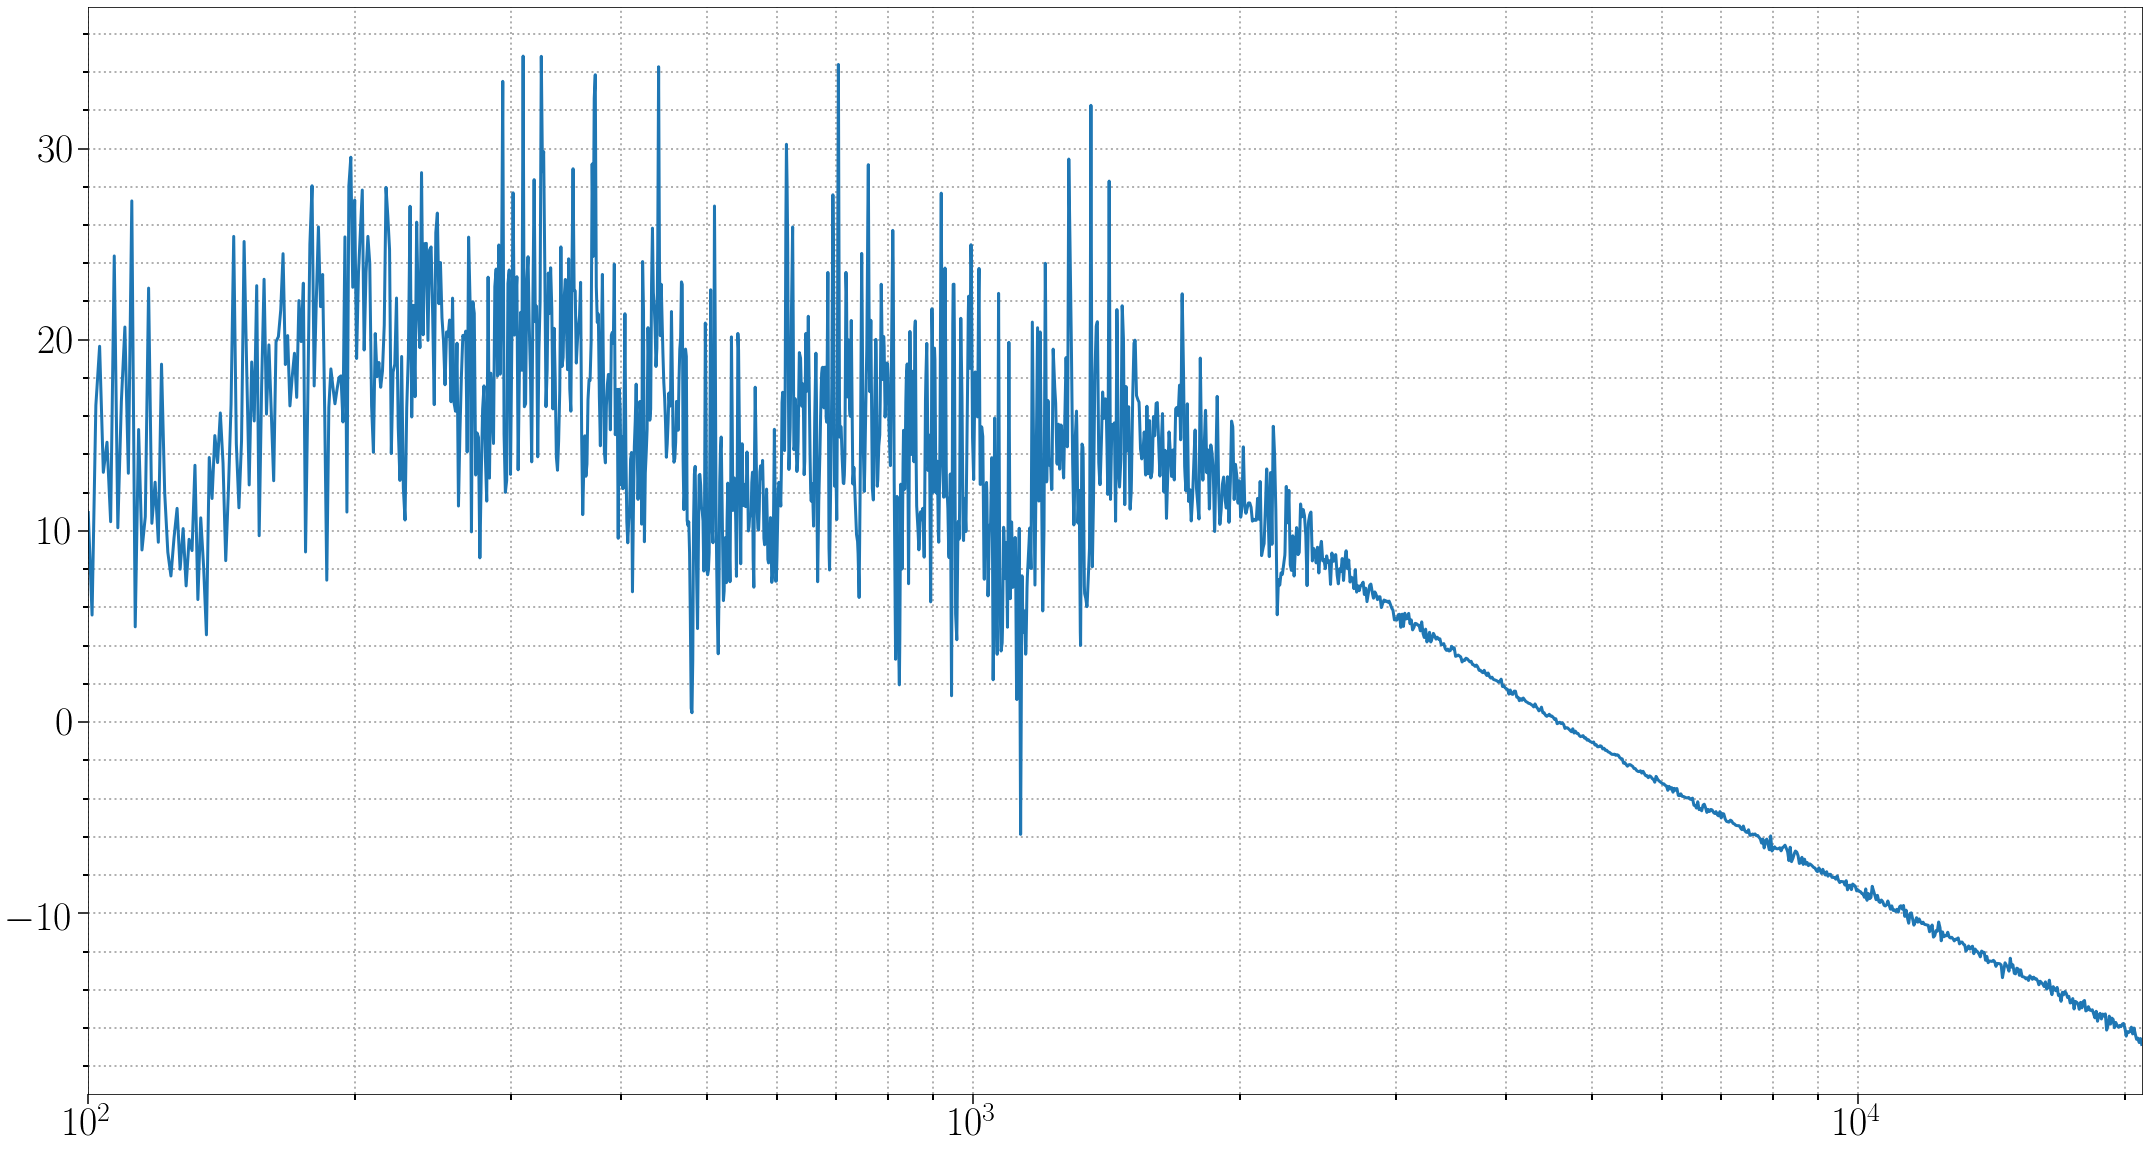

In [190]:
plt.semilogx(f['freq'], f['raw/olg/db'])
plt.xlim(f['freq'][0],f['freq'][-1])

In [175]:
f.close()

In [30]:
###### Directories
# Dates
sample = 'algaas'
date = ['01_25_2021','02_02_2021', '02_10_2021', '02_17_2021']

# single frequency drive? swept_frequency?
h1 = 'single_frequency'
h2 = 'swept_frequency'

# type of measurement
f1 = 'noise'
f2 = '300Vpkdrive'
f3 = 'err_spectra'
f4 = 'drive_freq'
f5 = 'hp_low_out_drive'

#Common directory
common_dir = '/Users/daniel_vander-hyde/Documents/git/SU/algaas_electrooptic_effect/measurements/'

vpkn1 = concat_vecs(common_dir  + h1 + '/' + sample + '/' + date[0] + '/' + f1 + '/') 

vpkd1 = concat_vecs(common_dir  + h1 + '/' + sample + '/'  + date[0] + '/' + f2 + '/')

vpkn2 = concat_vecs(common_dir + h1 + '/' + sample + '/'  + date[1] + '/' + f1 + '/') 

vpkd2 = concat_vecs(common_dir + h1 + '/' + sample + '/' +  date[1] + '/' + f2 + '/')

vpksw1 = concat_vecs(common_dir  + h2 + '/' + sample + '/' +  date[2] + '/' + f3 + '/')

vpkdr1 = concat_vecs(common_dir  + h2 + '/' + sample + '/' +  date[2] + '/' + f5 + '/')

vpksw2 = concat_vecs(common_dir  + h2 + '/' + sample + '/' +  date[3] + '/' + f3 + '/')

vpkdr2 = concat_vecs(common_dir  + h2 + '/' + sample + '/' +  date[3] + '/' + f5 + '/')

vpkswn2 = concat_vecs(common_dir  + h2 + '/' + sample + '/' +  date[3] + '/' + f1 + '/')
    

In [41]:
#OLG import
OLG_dir = common_dir +  'OLG/' + sample + '/'

#short_meas='TF1/'
long_meas = 'TF2/'

##JAN
#dbs = np.loadtxt(common_dir1 + date + short_meas + 'db.TXT')
dbl_data = np.loadtxt(OLG_dir + date[0] +'/' + long_meas + 'db.TXT')

#degs= np.loadtxt(common_dir1 + date + short_meas + 'deg.TXT')
degl_data = np.loadtxt(OLG_dir + date[0] +'/'+ long_meas + 'deg.TXT')

##FEB
db2_data = np.loadtxt(OLG_dir + date[1] +'/' + 'db.TXT')

#degs= np.loadtxt(common_dir1 + date + short_meas + 'deg.TXT')
deg2_data = np.loadtxt(OLG_dir + date[1] +'/' + 'deg.TXT')


##Swept Frequency OLG measurements
db3_data = np.loadtxt(OLG_dir + date[3] + '/' + 'db.TXT')
deg3_data = np.loadtxt(OLG_dir + date[3] + '/' + 'deg.TXT')


#Organize arrays
f_olg1 = dbl_data[:,0]
db1 = dbl_data[:,1]
deg1 = degl_data[:,1]

f_olg2 = db2_data[:,0]
db2 = db2_data[:,1]
deg2 = deg2_data[:,1]

f_olg3 = db3_data[:,0]
db3 = db3_data[:,1]
deg3 = deg3_data[:,1]

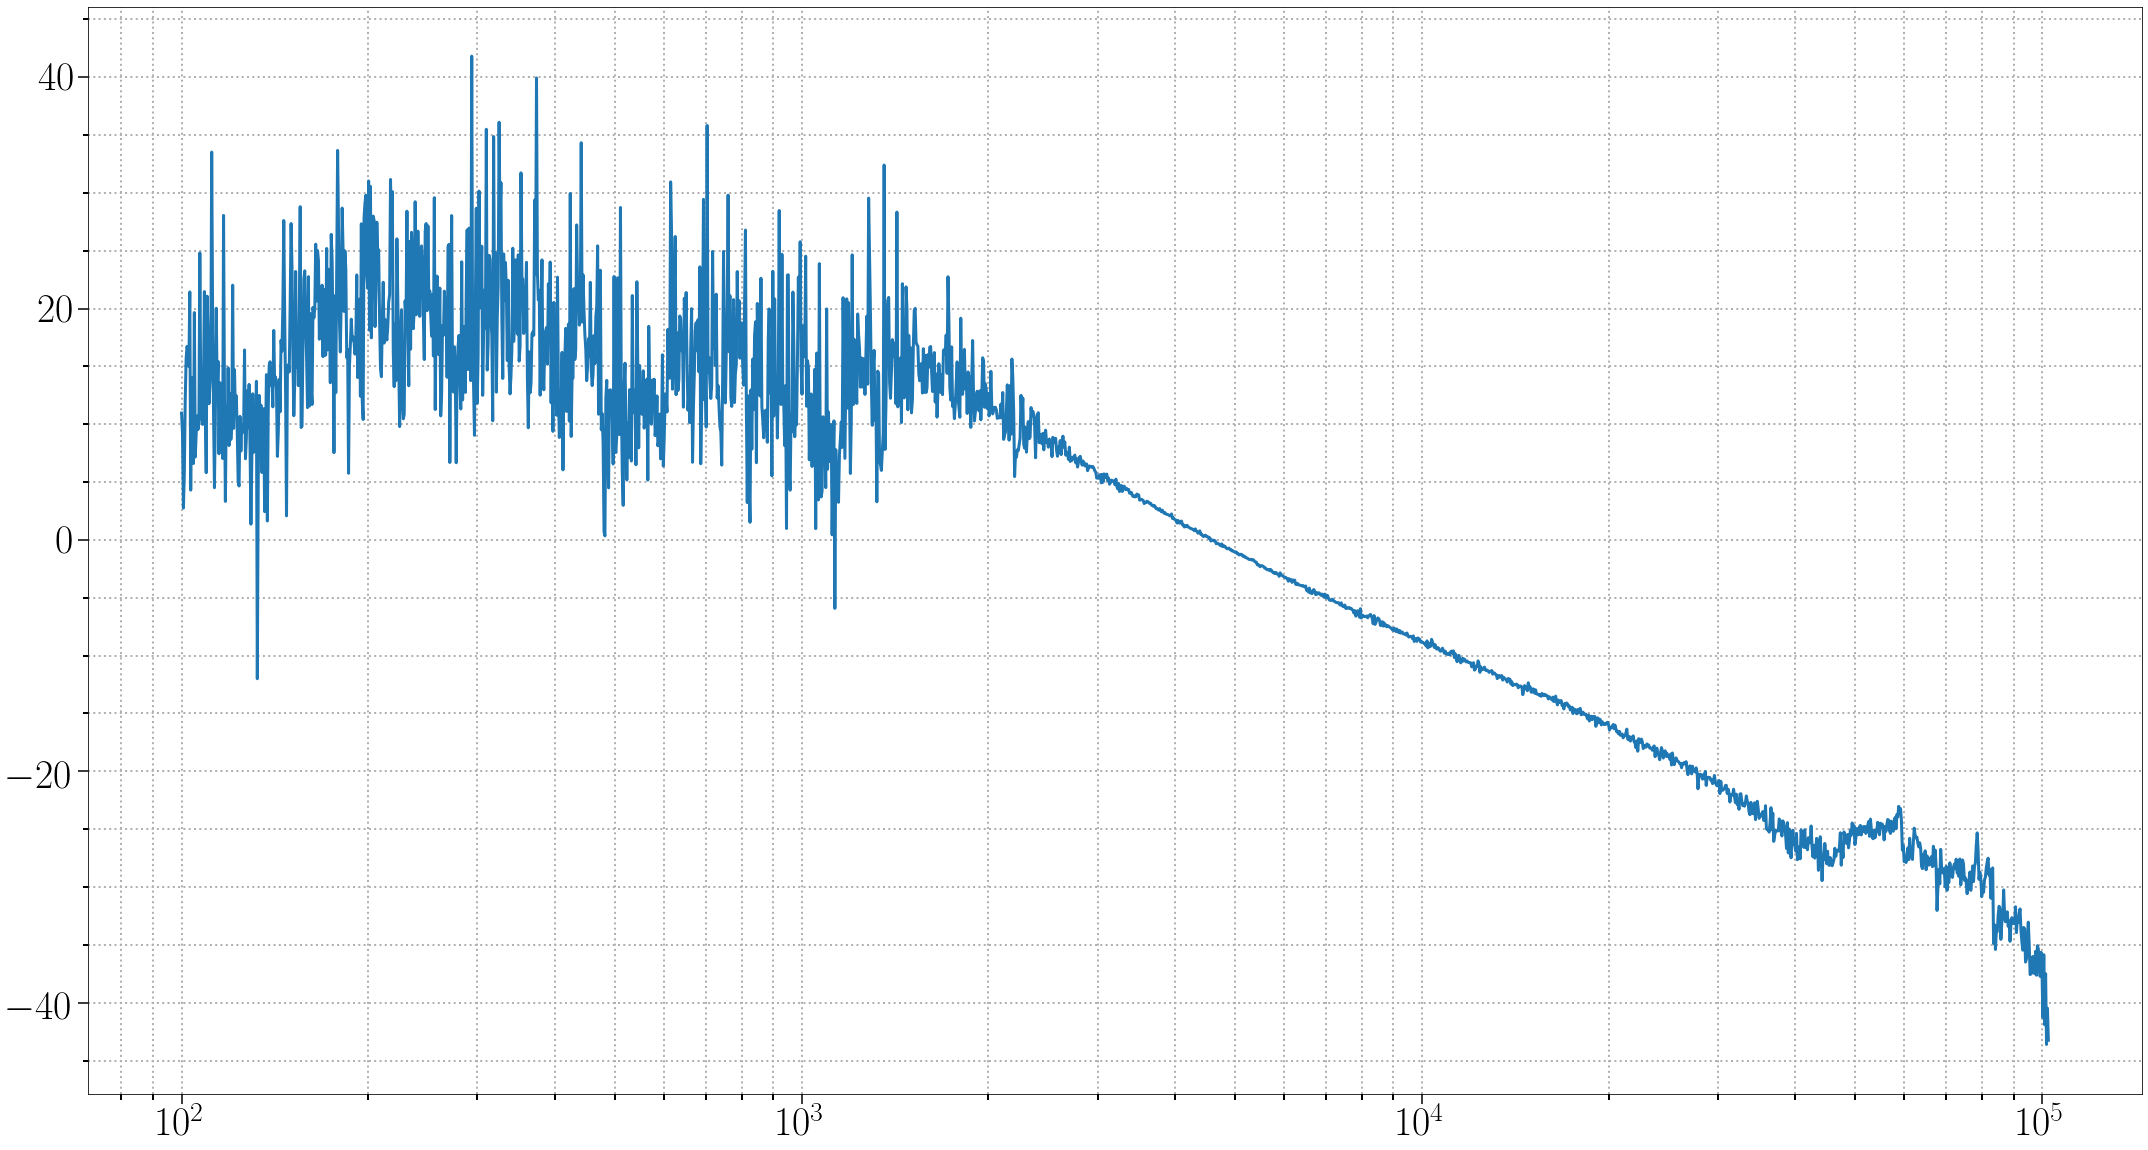

In [191]:
plt.semilogx(f_olg3, db3)

In [33]:
#HVA
hva1_dir = '/Users/daniel_vander-hyde/Documents/git/SU/algaas_electrooptic_effect/measurements/HVASVR_tf/HVACH3_plus_pomona/02_19_2020/'
hva2_dir = '/Users/daniel_vander-hyde/Documents/git/SU/algaas_electrooptic_effect/measurements/HVASVR_tf/HVACH3_plus_pomona/' + date[3] + '/'
#HVA (A(f))
hva1db = np.loadtxt(hva1_dir + 'db.TXT')                       #HVA + pomona box (Knob setting = halfway to full)
hva1deg = np.loadtxt(hva1_dir + 'deg.TXT')  

hva2db = np.loadtxt(hva2_dir + 'db.TXT')                       #HVA + pomona box (Knob setting = three quarters to full)
hva2deg = np.loadtxt(hva2_dir + 'deg.TXT') 



In [34]:
#COMMON FREQUENCY VECTOR
fff = vpksw2[0]

AttributeError: 'numpy.ndarray' object has no attribute 'dim'

In [46]:
#Interpolate vectors


#OLG (January measurements)
olgdb_inter1 = np.interp(fff,f_olg1,db1)
olgdeg_inter1 = np.interp(fff,f_olg1,deg1)

#OLG (Febuary measurements)
olgdb_inter2 = np.interp(fff, f_olg2, db2)
olgdeg_inter2 = np.interp(fff, f_olg2, deg2)

#OLG (FEB 17,2021)
olgdb_inter3 = np.interp(fff, f_olg3, db3)
olgdeg_inter3 = np.interp(fff, f_olg3, deg3)

#HVA (January measurements)    
hva1db_inter = np.interp(fff, hva1db[:,0], hva1db[:,1])
hva1deg_inter = np.interp(fff,hva1deg[:,0], hva1deg[:,1])  

#Febuary 20th 2021 measurements
hva2db_inter = np.interp(fff, hva2db[:,0], hva2db[:,1])
hva2deg_inter = np.interp(fff,hva2deg[:,0], hva2deg[:,1])


In [36]:
fff3 = vpkd2[0]
fff2 = vpkn2[0]

(100.0, 32100.0)

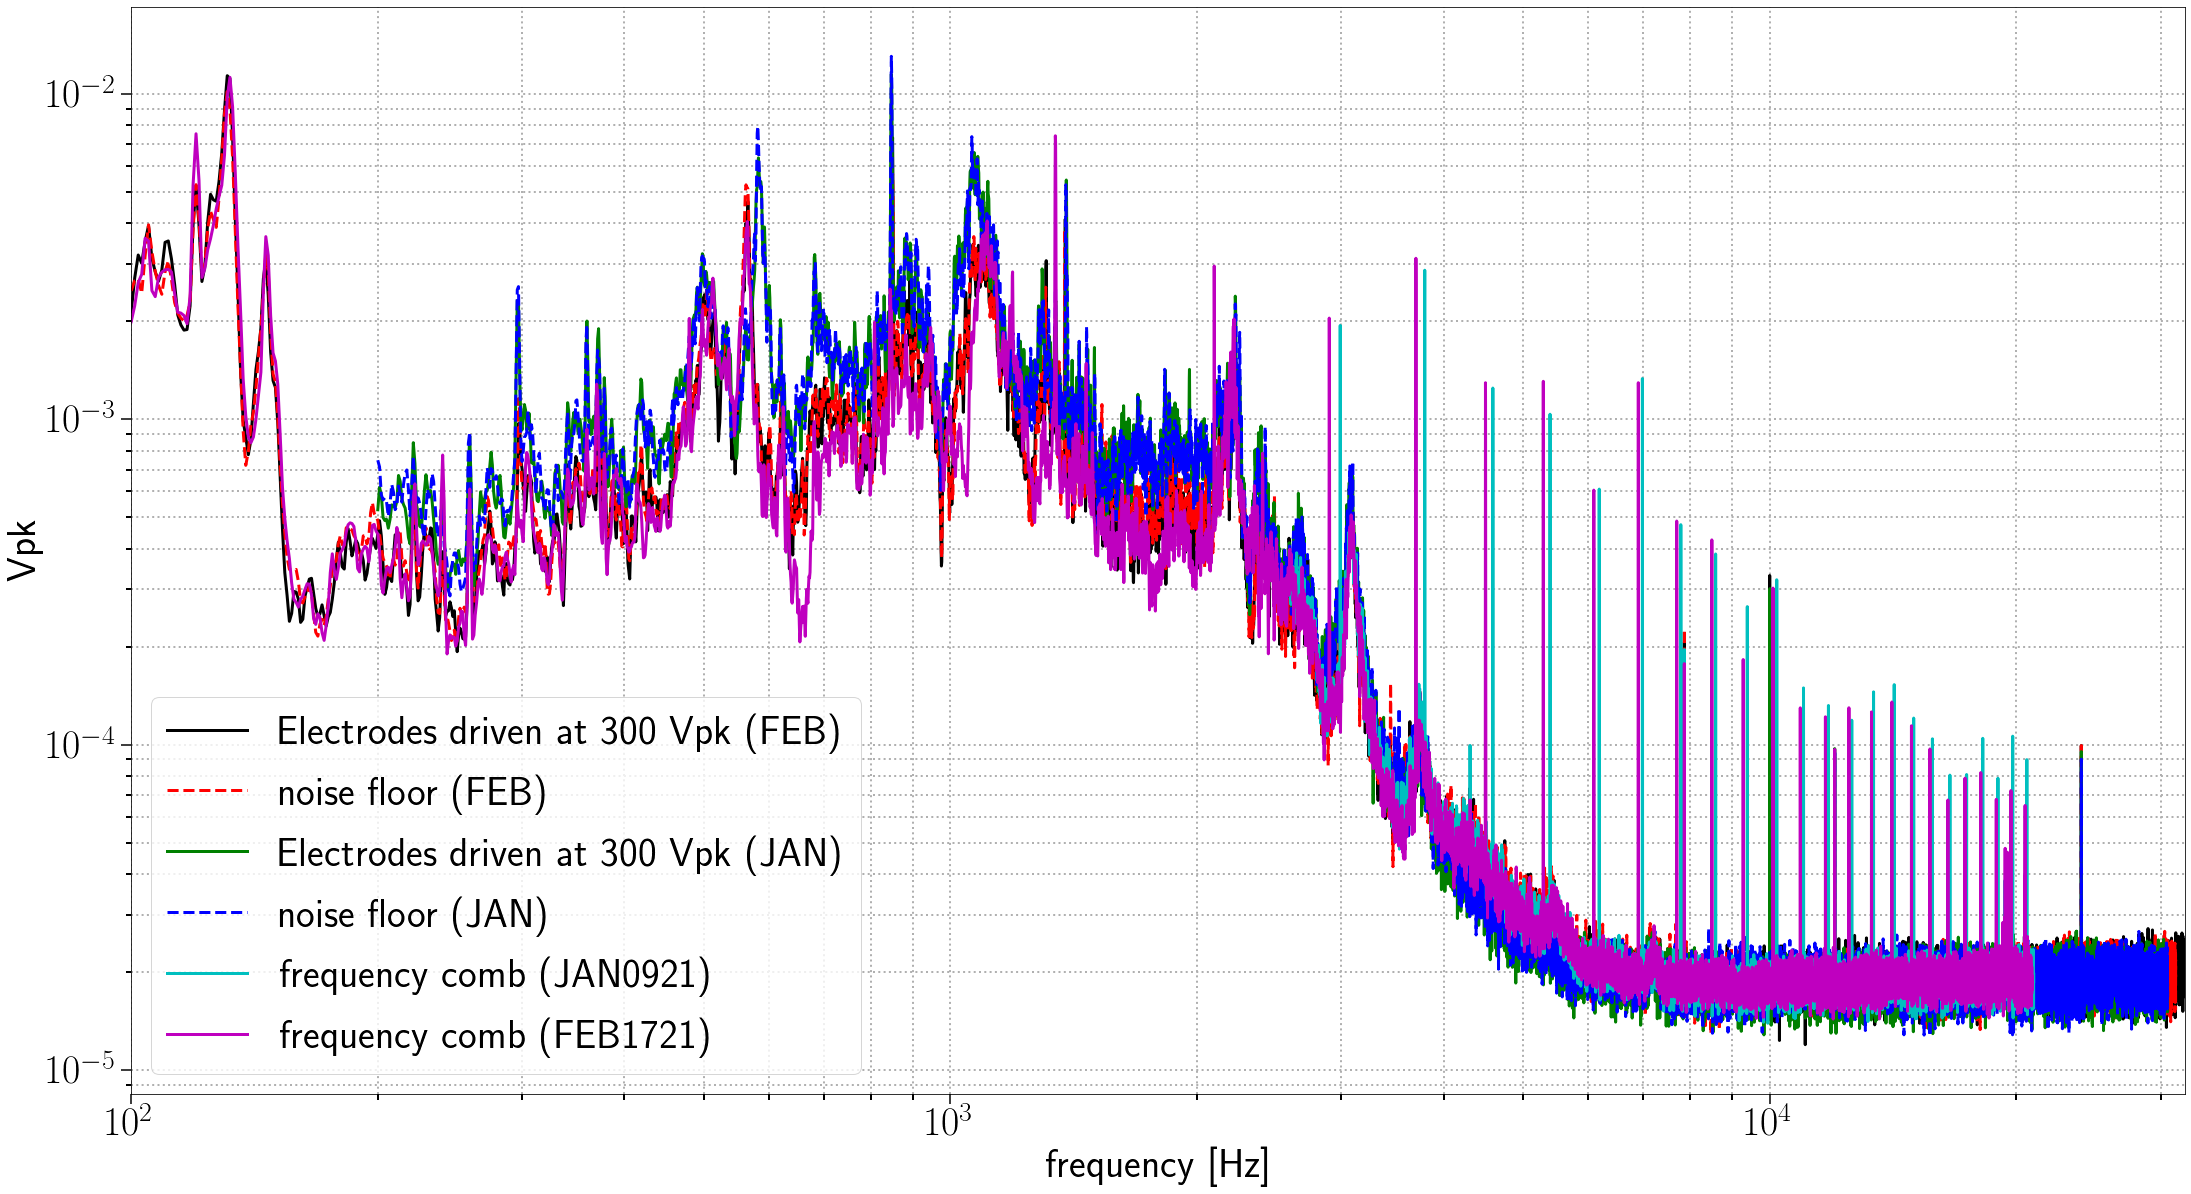

In [40]:
plt.loglog(fff3,vpkd2[1], color='k', label='Electrodes driven at 300 Vpk (FEB)')
plt.loglog(fff2,vpkn2[1], color='r', linestyle='--', label='noise floor (FEB)')
plt.loglog(vpkd1[0],vpkd1[1], color='g', label='Electrodes driven at 300 Vpk (JAN)')
plt.loglog(vpkn1[0],vpkn1[1], color='b', linestyle='--', label='noise floor (JAN)')
plt.loglog(vpksw1[0], vpksw1[1], color='c', label= 'frequency comb (JAN0921)')
plt.loglog(vpksw2[0], vpksw2[1], color='m', label = 'frequency comb (FEB1721)')
plt.legend()
plt.xlabel('frequency [Hz]')
plt.ylabel('Vpk')
plt.xlim([fff3[0],fff3[-1]])

In [10]:
vpkd2_interp = np.interp(fff,fff3, vpkd2[1])
vpkn2_interp = np.interp(fff,fff2, vpkn2[1])

(200.0, 30600.0)

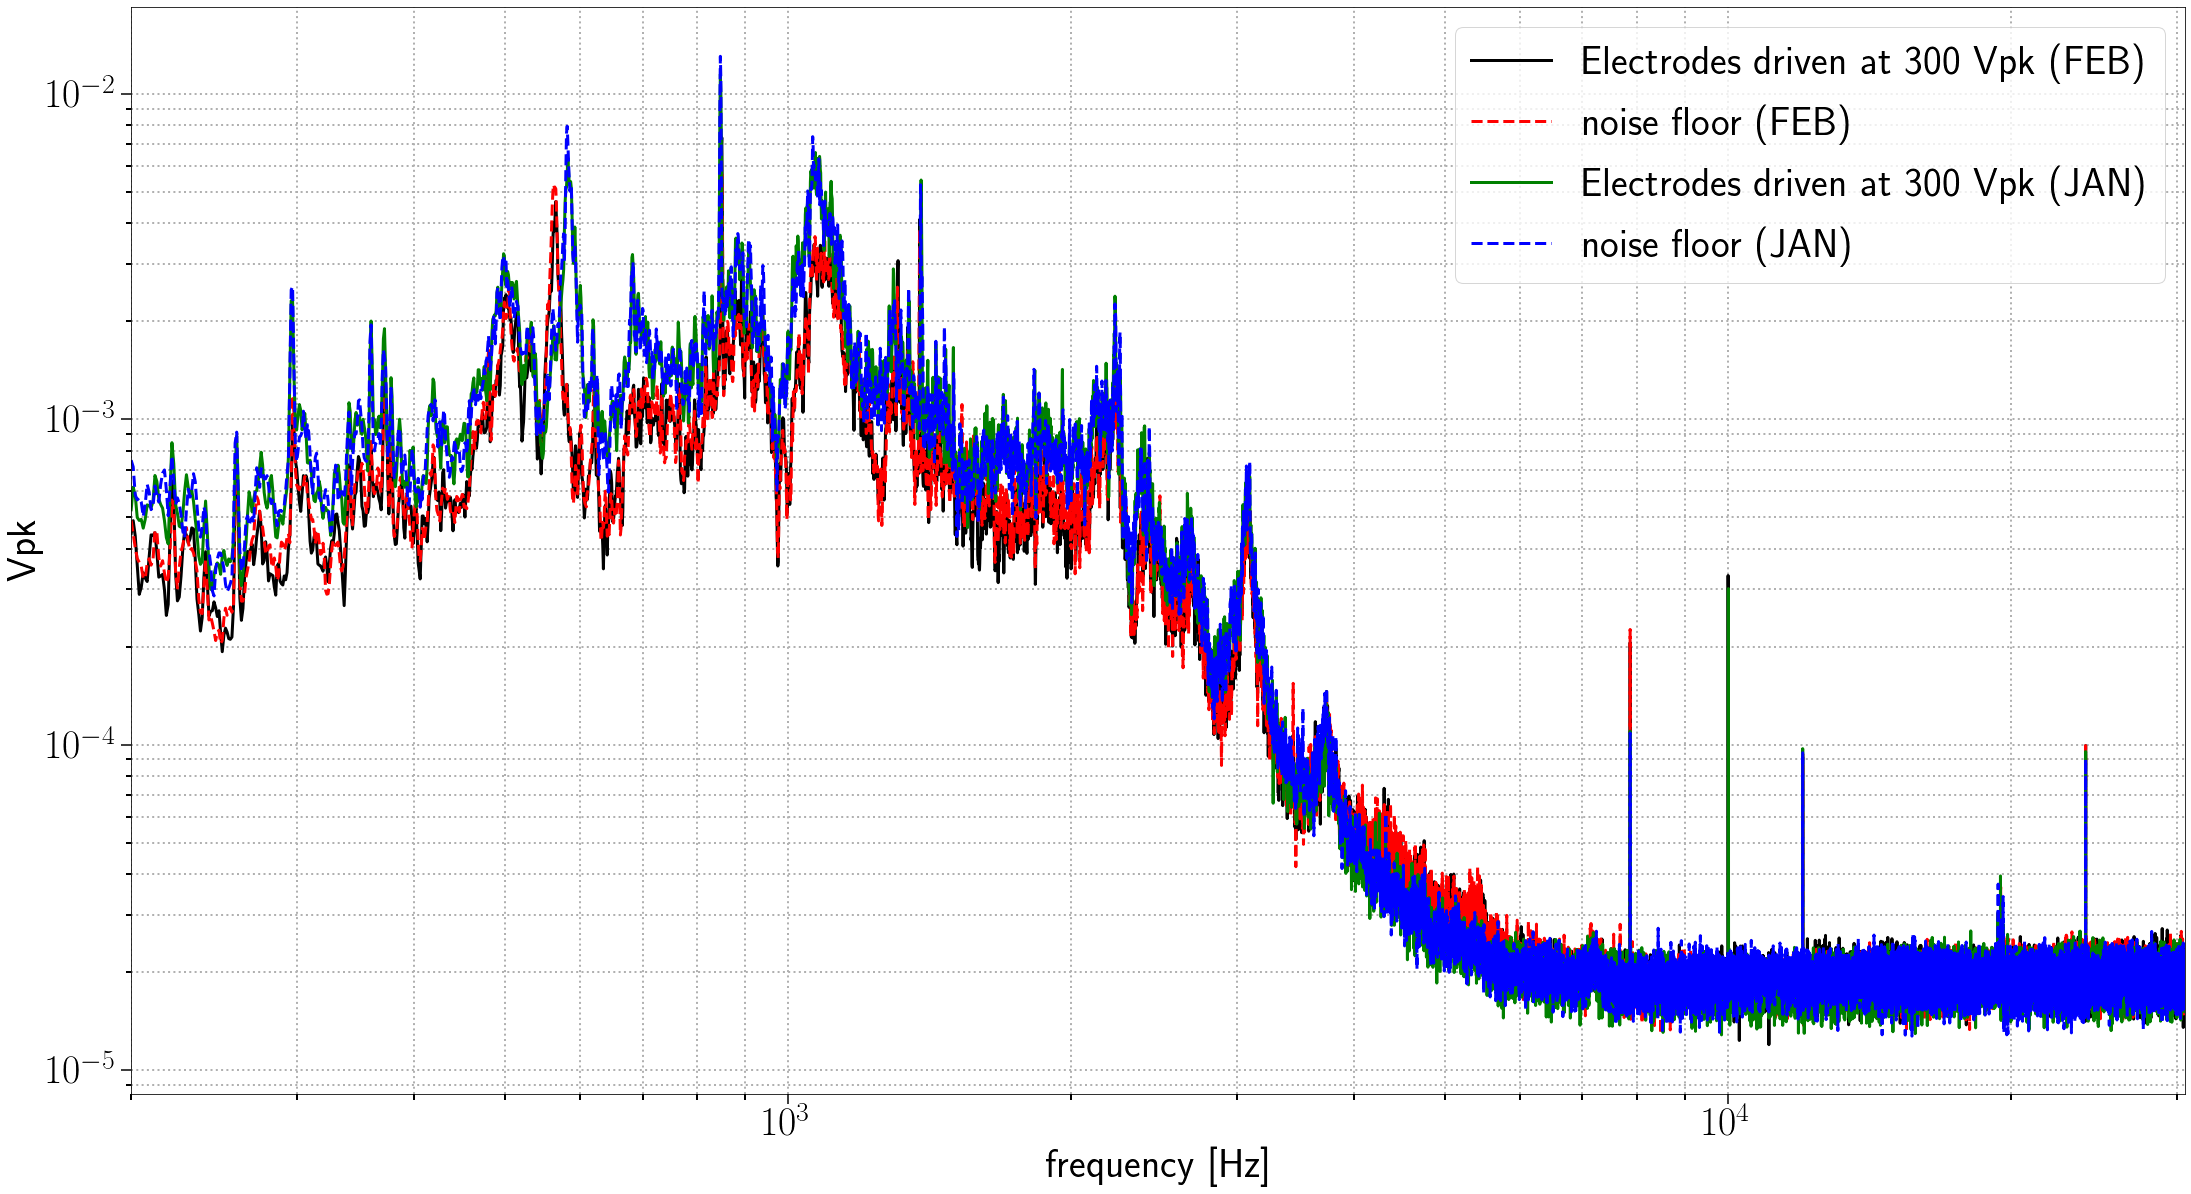

In [11]:
plt.loglog(fff,vpkd2_interp, color='k', label='Electrodes driven at 300 Vpk (FEB)')
plt.loglog(fff,vpkn2_interp, color='r', linestyle='--', label='noise floor (FEB)')
plt.loglog(fff,vpkd1[1], color='g', label='Electrodes driven at 300 Vpk (JAN)')
plt.loglog(fff,vpkn1[1], color='b', linestyle='--', label='noise floor (JAN)')
plt.legend()
plt.xlabel('frequency [Hz]')
plt.ylabel('Vpk')
plt.xlim([fff[0],fff[-1]])

Text(0.5, 0, 'frequency [Hz]')

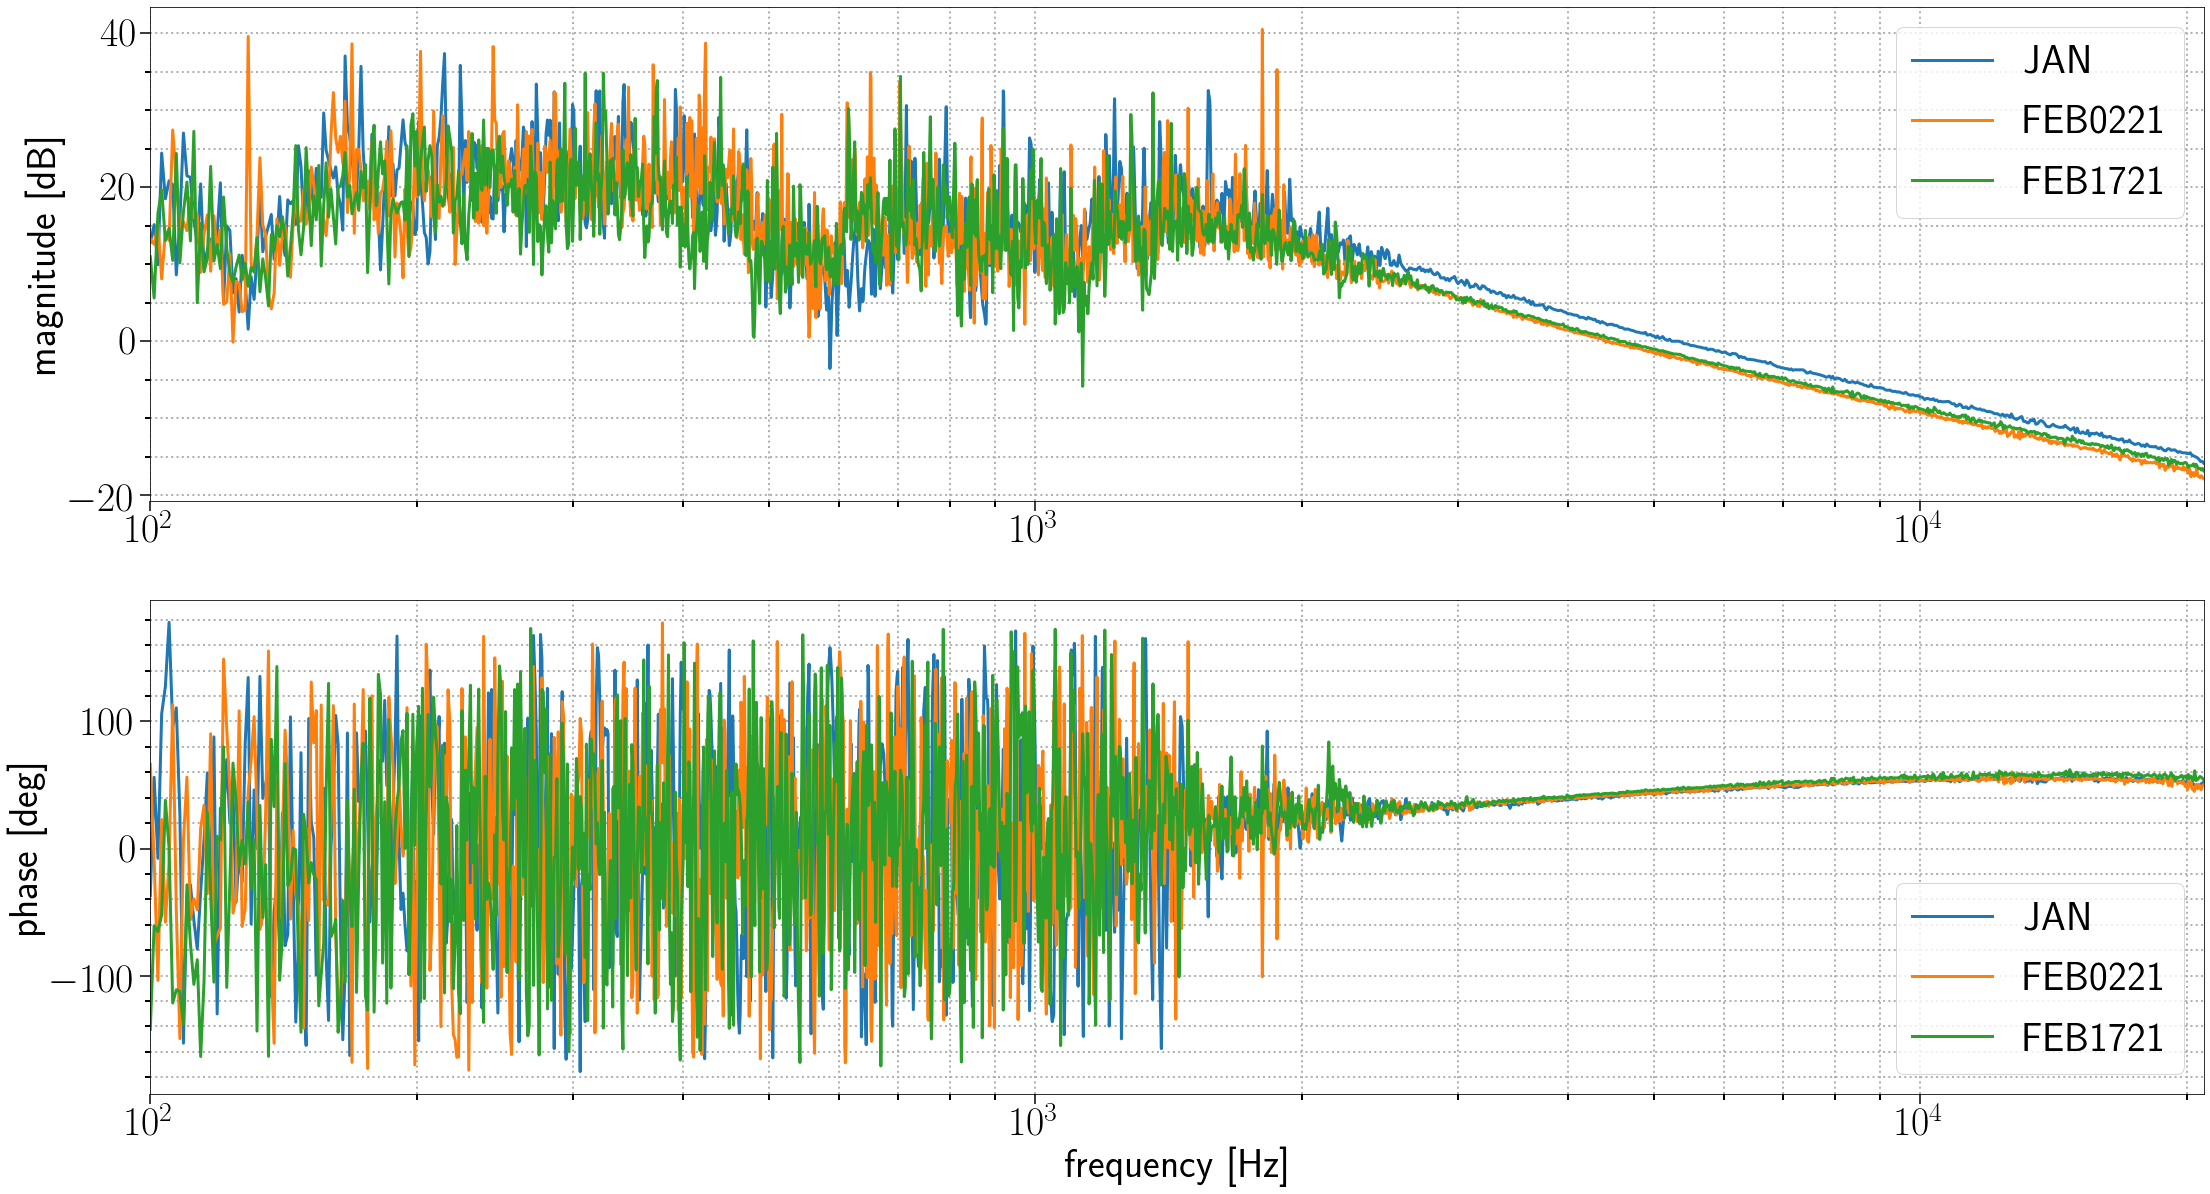

In [48]:
plt.subplot(211)
plt.semilogx(fff, olgdb_inter1, label = 'JAN')
plt.semilogx(fff, olgdb_inter2, label = 'FEB0221')
plt.semilogx(fff, olgdb_inter3, label='FEB1721')
plt.legend()
plt.ylabel('magnitude [dB]')
plt.xlim([fff[0],fff[-1]])
plt.subplot(212)
plt.semilogx(fff,olgdeg_inter1, label='JAN')
plt.semilogx(fff,olgdeg_inter2, label='FEB0221')
plt.semilogx(fff,olgdeg_inter3, label='FEB1721')
plt.legend()
plt.xlim([fff[0],fff[-1]])
plt.ylabel('phase [deg]')
plt.xlabel('frequency [Hz]')

Text(0.5, 0, 'Frequency [Hz]')

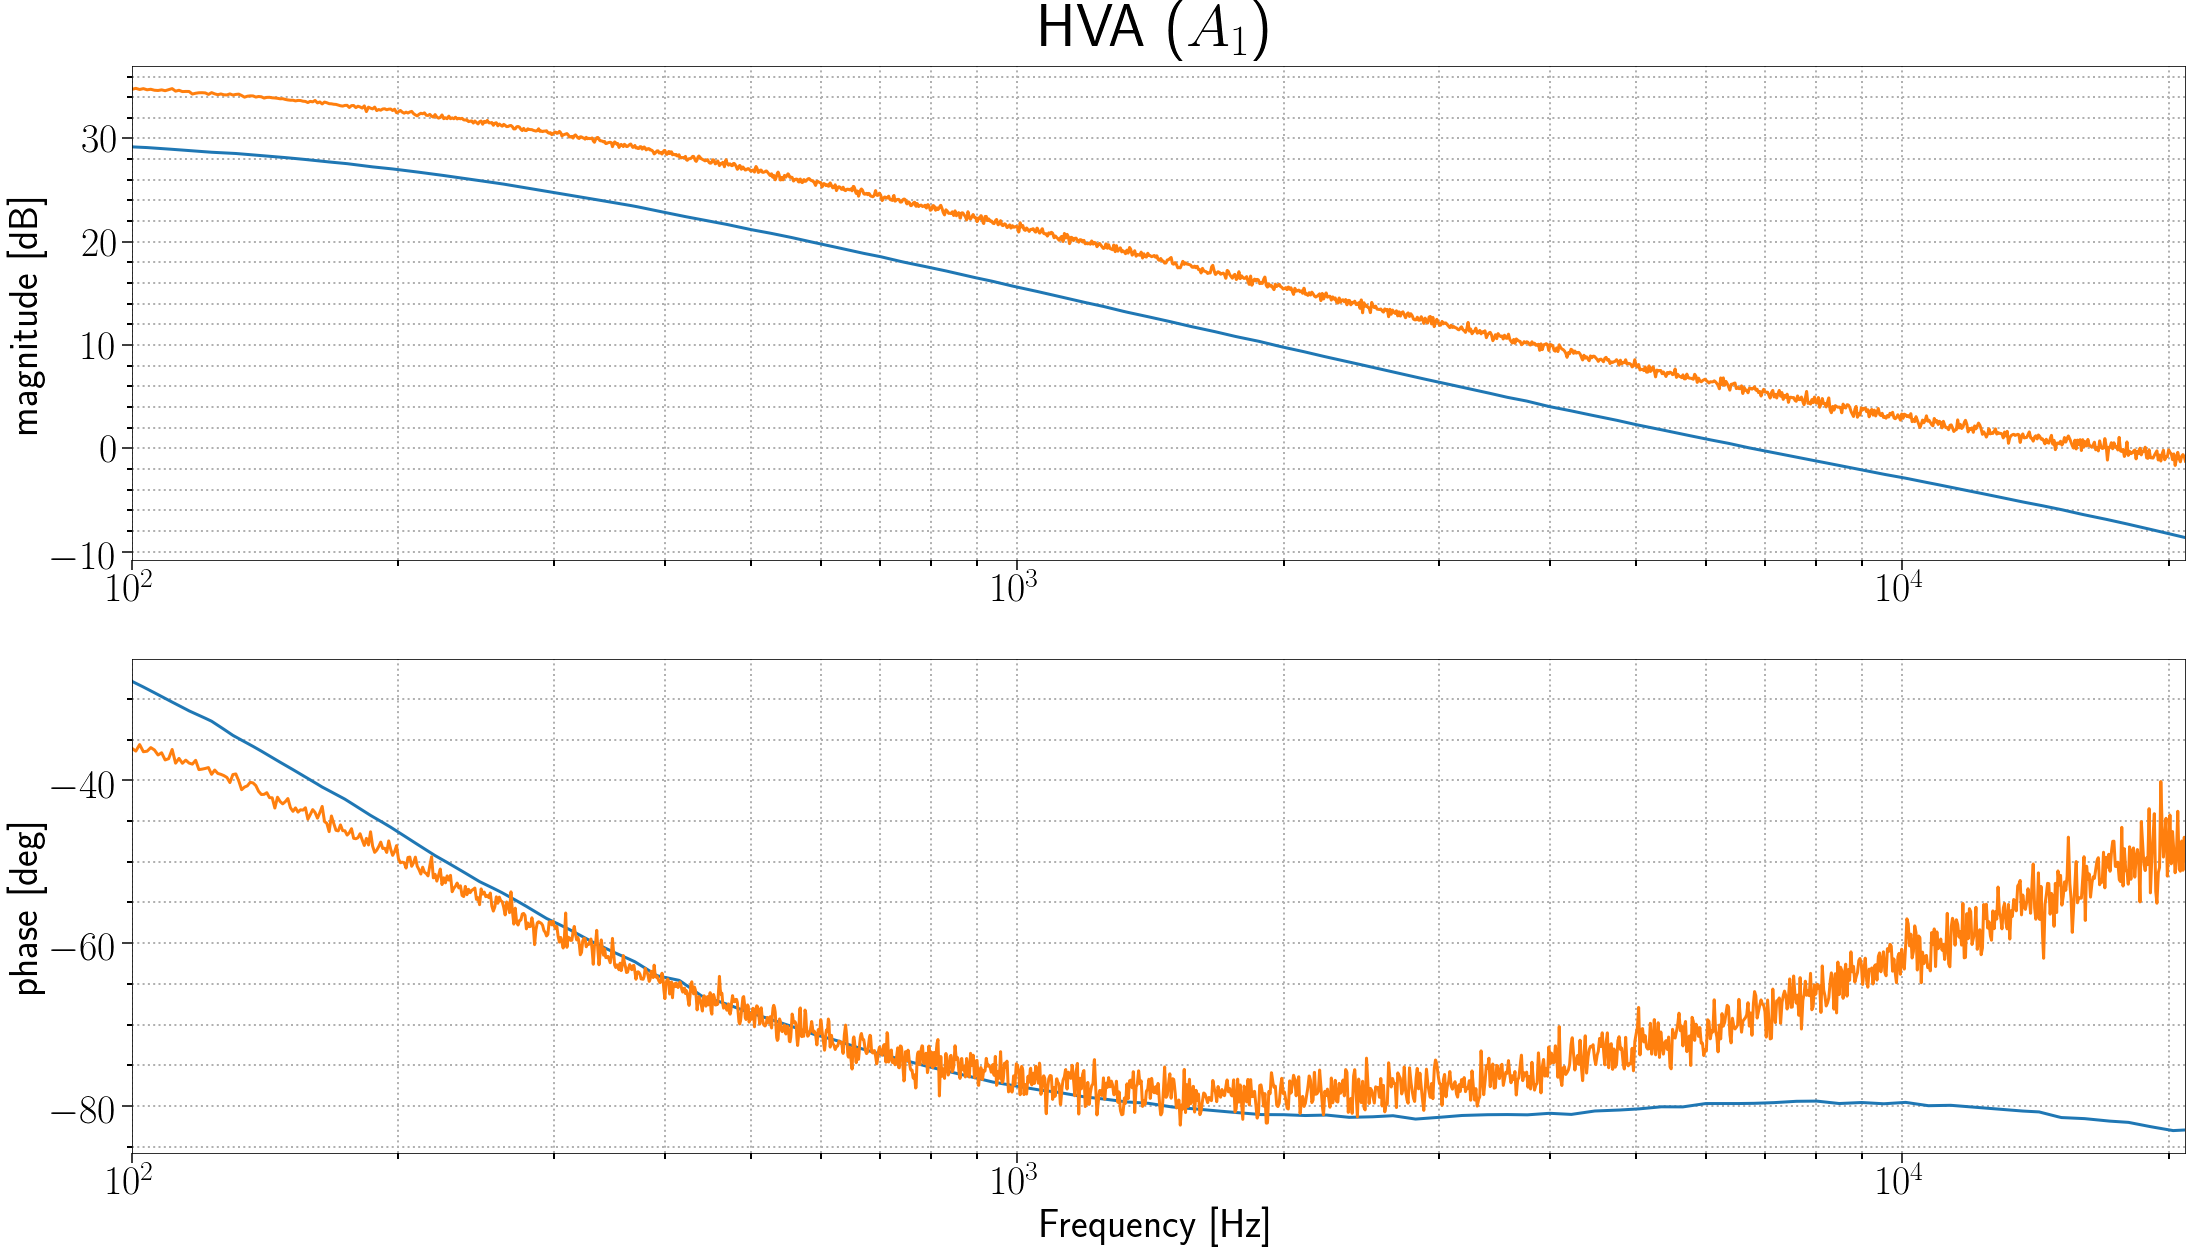

In [50]:
plt.subplot(211)
plt.semilogx(fff, hva1db_inter, label = 'HVA 50% gain')
plt.semilogx(fff, hva2db_inter, label = 'HVA 75% gain')
plt.ylabel('magnitude [dB]')
plt.xlim([fff[0],fff[-1]])
plt.title('HVA ($A_1$)')
plt.subplot(212)
plt.semilogx(fff, hva1deg_inter, label = 'HVA 50% gain')
plt.semilogx(fff,hva2deg_inter, label = 'HVA 75% gain')
plt.xlim([fff[0],fff[-1]])
plt.ylabel('phase [deg]')
plt.xlabel('Frequency [Hz]')

In [57]:
OLG1 = transfer_function(olgdb_inter1, olgdeg_inter1)
HVA1 = transfer_function(hva1db_inter, hva1deg_inter)
OLG2 = transfer_function(olgdb_inter2, olgdeg_inter2)
OLG3 = transfer_function(olgdb_inter3, olgdeg_inter3)
HVA2 = transfer_function(hva2db_inter, hva2deg_inter)

In [63]:
laserV2Hz = 2.0e6
HzpV1 = HVA1*laserV2Hz
HzpV2 = HVA2*laserV2Hz

In [64]:
CLG1 = 1/(1-OLG1)
CLG2 = 1/(1-OLG2)
CLG3 = 1/(1-OLG3)
CAL1=OLG1*CLG1
CAL2=OLG2*CLG2
CAL3=OLG3*CLG3
CALVpHz1=CAL1/HzpV
CALHzpV1=HzpV1/CAL1
CALVpHz2=CAL2/HzpV
CALHzpV2=HzpV1/CAL2
CALHzpV3=HzpV2/CAL3

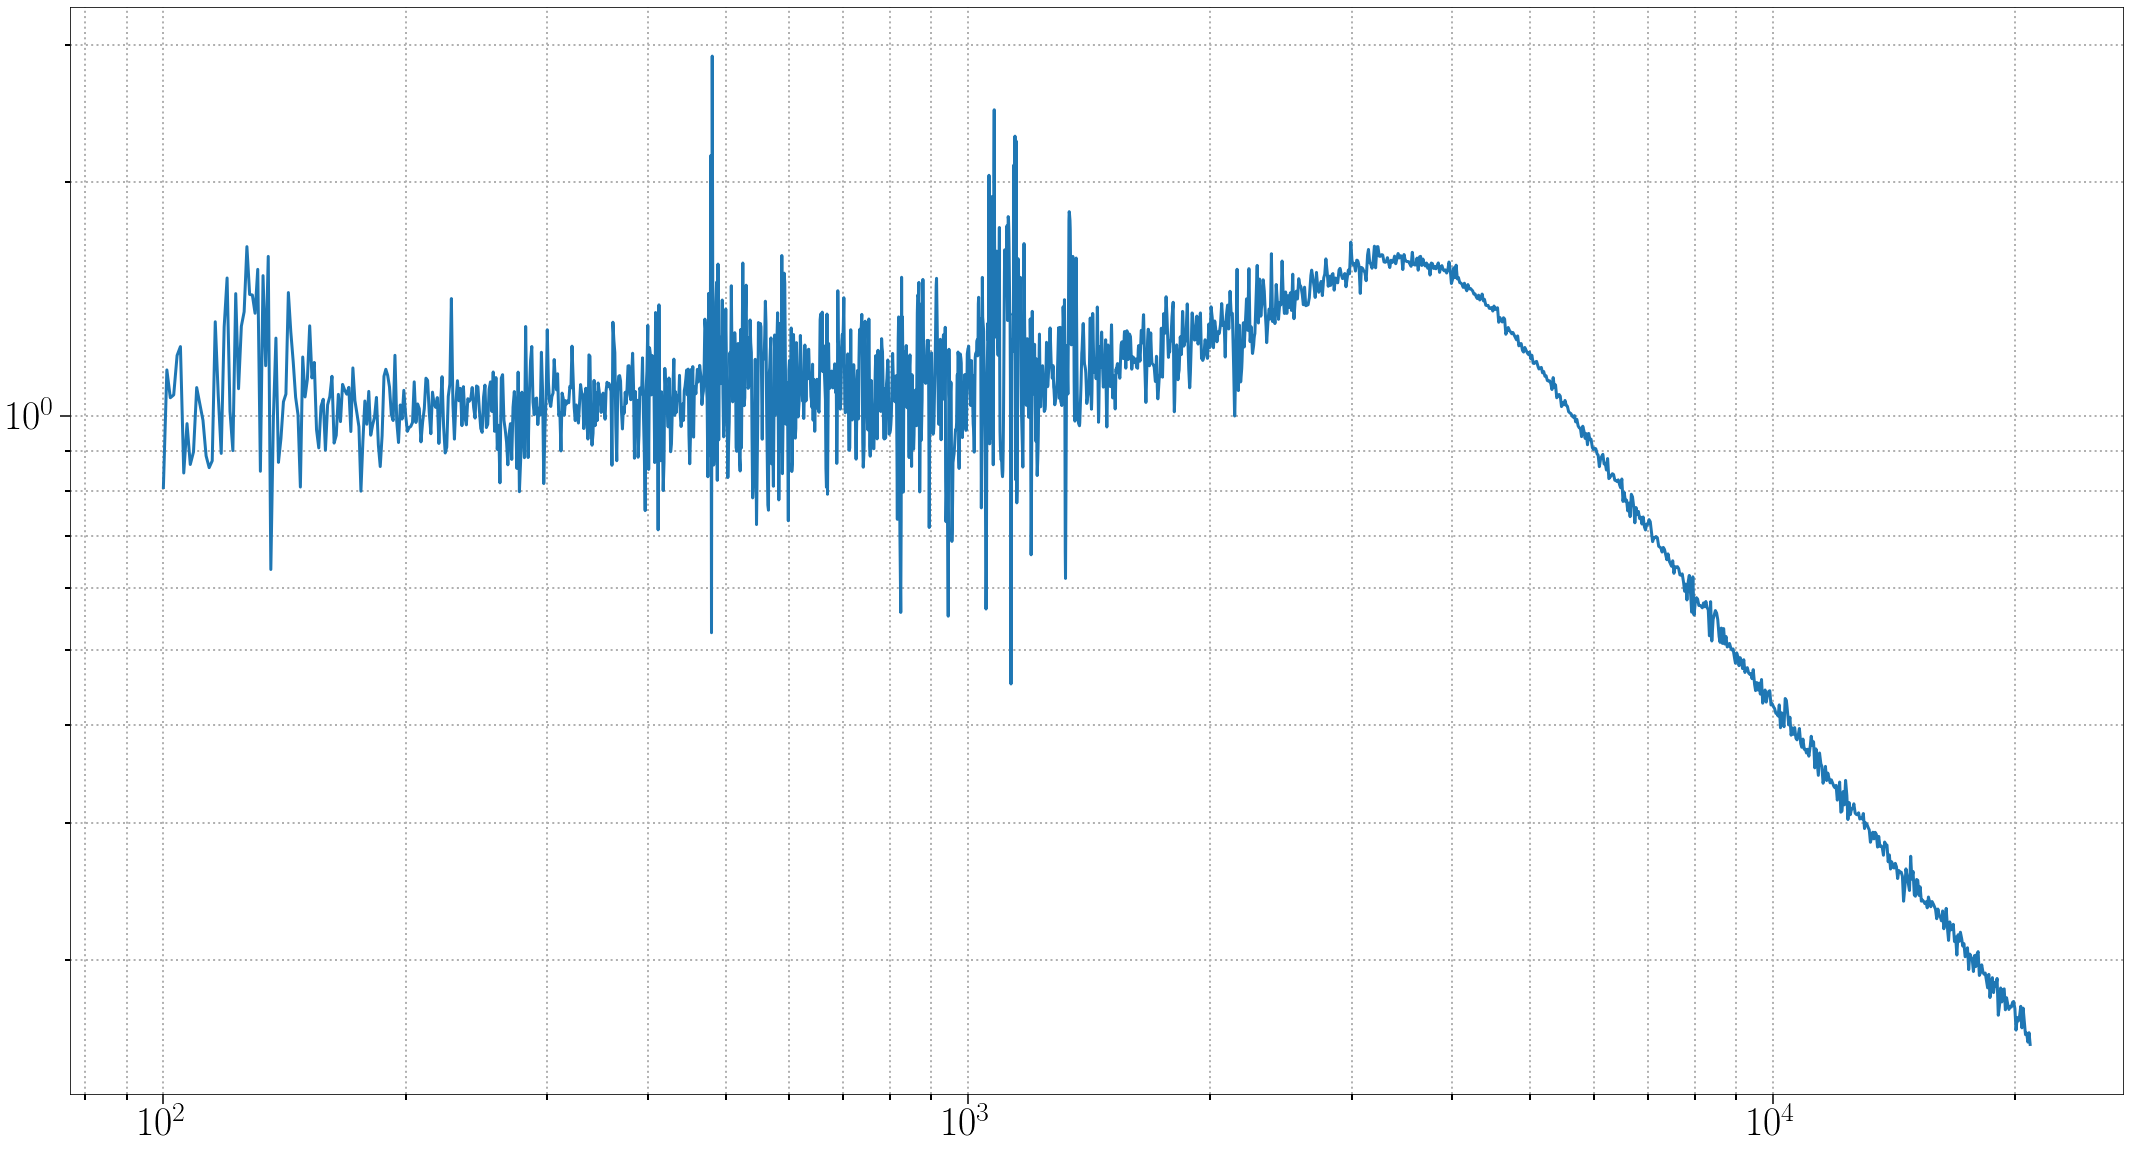

In [65]:
plt.loglog(fff,abs(CAL3))

In [75]:
#nHz1 = abs(CALHzpV1)*vpkn1[1]
#dHz1 = abs(CALHzpV1)*vpkd1[1]
#nHz2 = abs(CALHzpV2)*vpkn2_interp
#dHz2 = abs(CALHzpV2)*vpkd2_interp
swHz1 = abs(CALHzpV3)*vpksw2[1]
swnHz1 = abs(CALHzpV3)*vpkswn2[1]

Text(0.5, 1.0, 'Laser frequency noise from measured voltage noise')

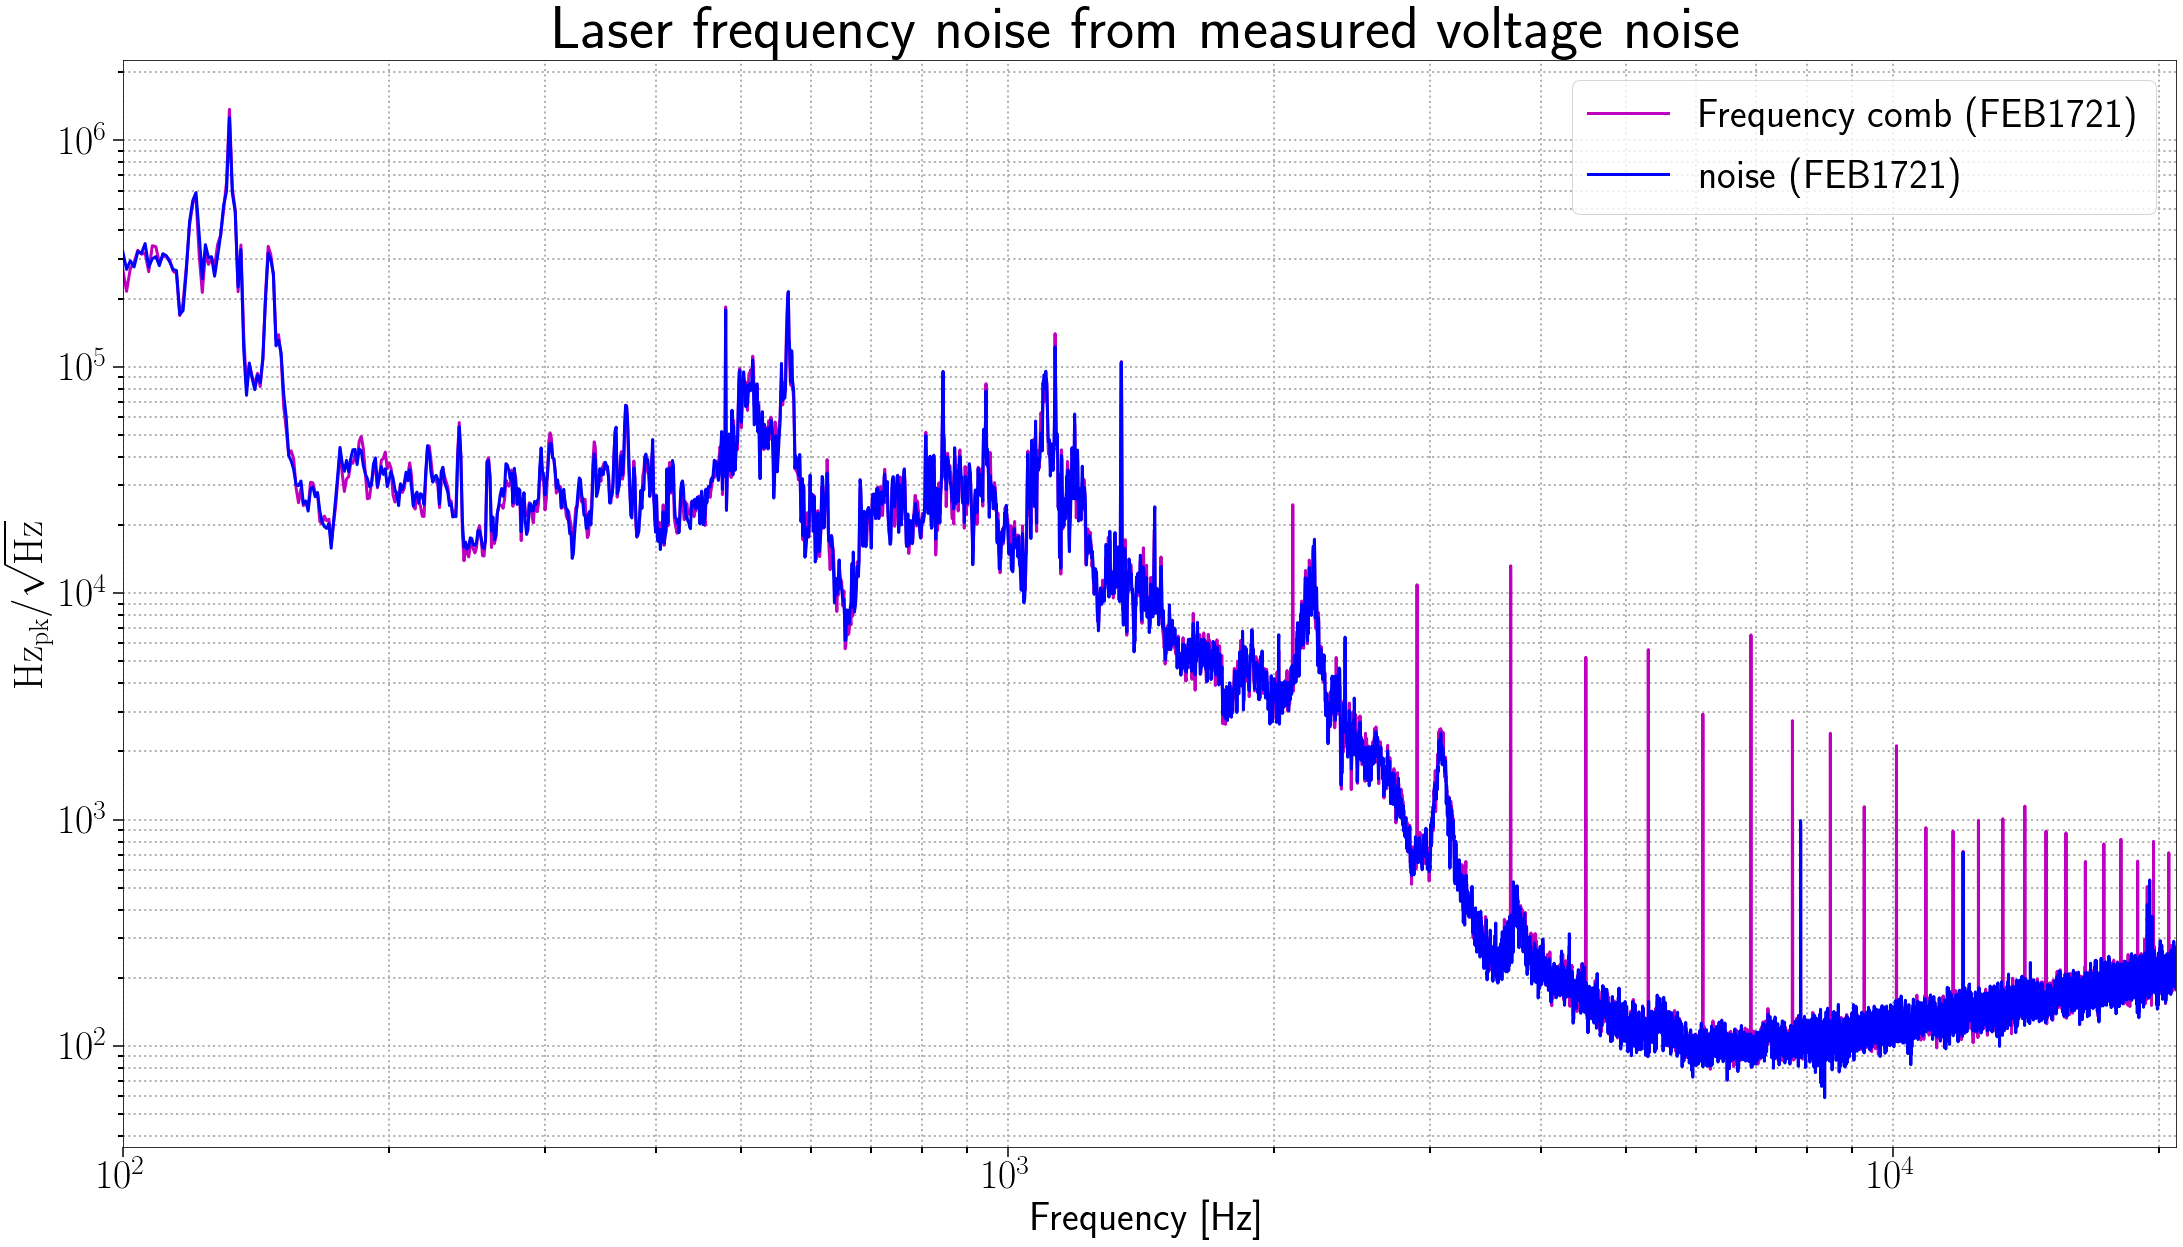

In [76]:
#plt.loglog(fff,dHz2, color='k',label='Electrodes driven [$V_\mathrm{electrode}= 300\; V_\mathrm{pk}$ @ 10000 Hz with amorphous coating] (FEB)', linewidth=3)
#plt.loglog(fff,nHz2, color = 'r', label='Noise (FEB)',linewidth=3)
#plt.loglog(fff,dHz1, color='g',label='Electrodes driven [$V_\mathrm{electrode}= 300\; V_\mathrm{pk}$ @ 10000 Hz with amorphous coating] (JAN)', linewidth=3)
#plt.loglog(fff,nHz1, color = 'b', label='Noise (JAN)',linewidth=3)
#plt.loglog(fn,nddHz,color='r',label='Electrodes undriven with AlGaAs coating', linewidth=3)
plt.loglog(fff,swHz1, color = 'm', label='Frequency comb (FEB1721)',linewidth=3)
plt.loglog(fff,swnHz1, color = 'b', label='noise (FEB1721)',linewidth=3)
plt.xlim([fff[0], fff[-1]])
plt.legend()
plt.xlabel('Frequency [Hz]')
plt.ylabel('$$\mathrm{Hz}_\mathrm{pk}/\sqrt{\mathrm{Hz}}$$')
plt.title("Laser frequency noise from measured voltage noise")

In [77]:
c = 299792458
lamb =1.064e-6
nu = c/lamb
Lcav = 0.165

Text(0.5, 1.0, 'Displacement spectra for AlGaAs Electro-optic measurement')

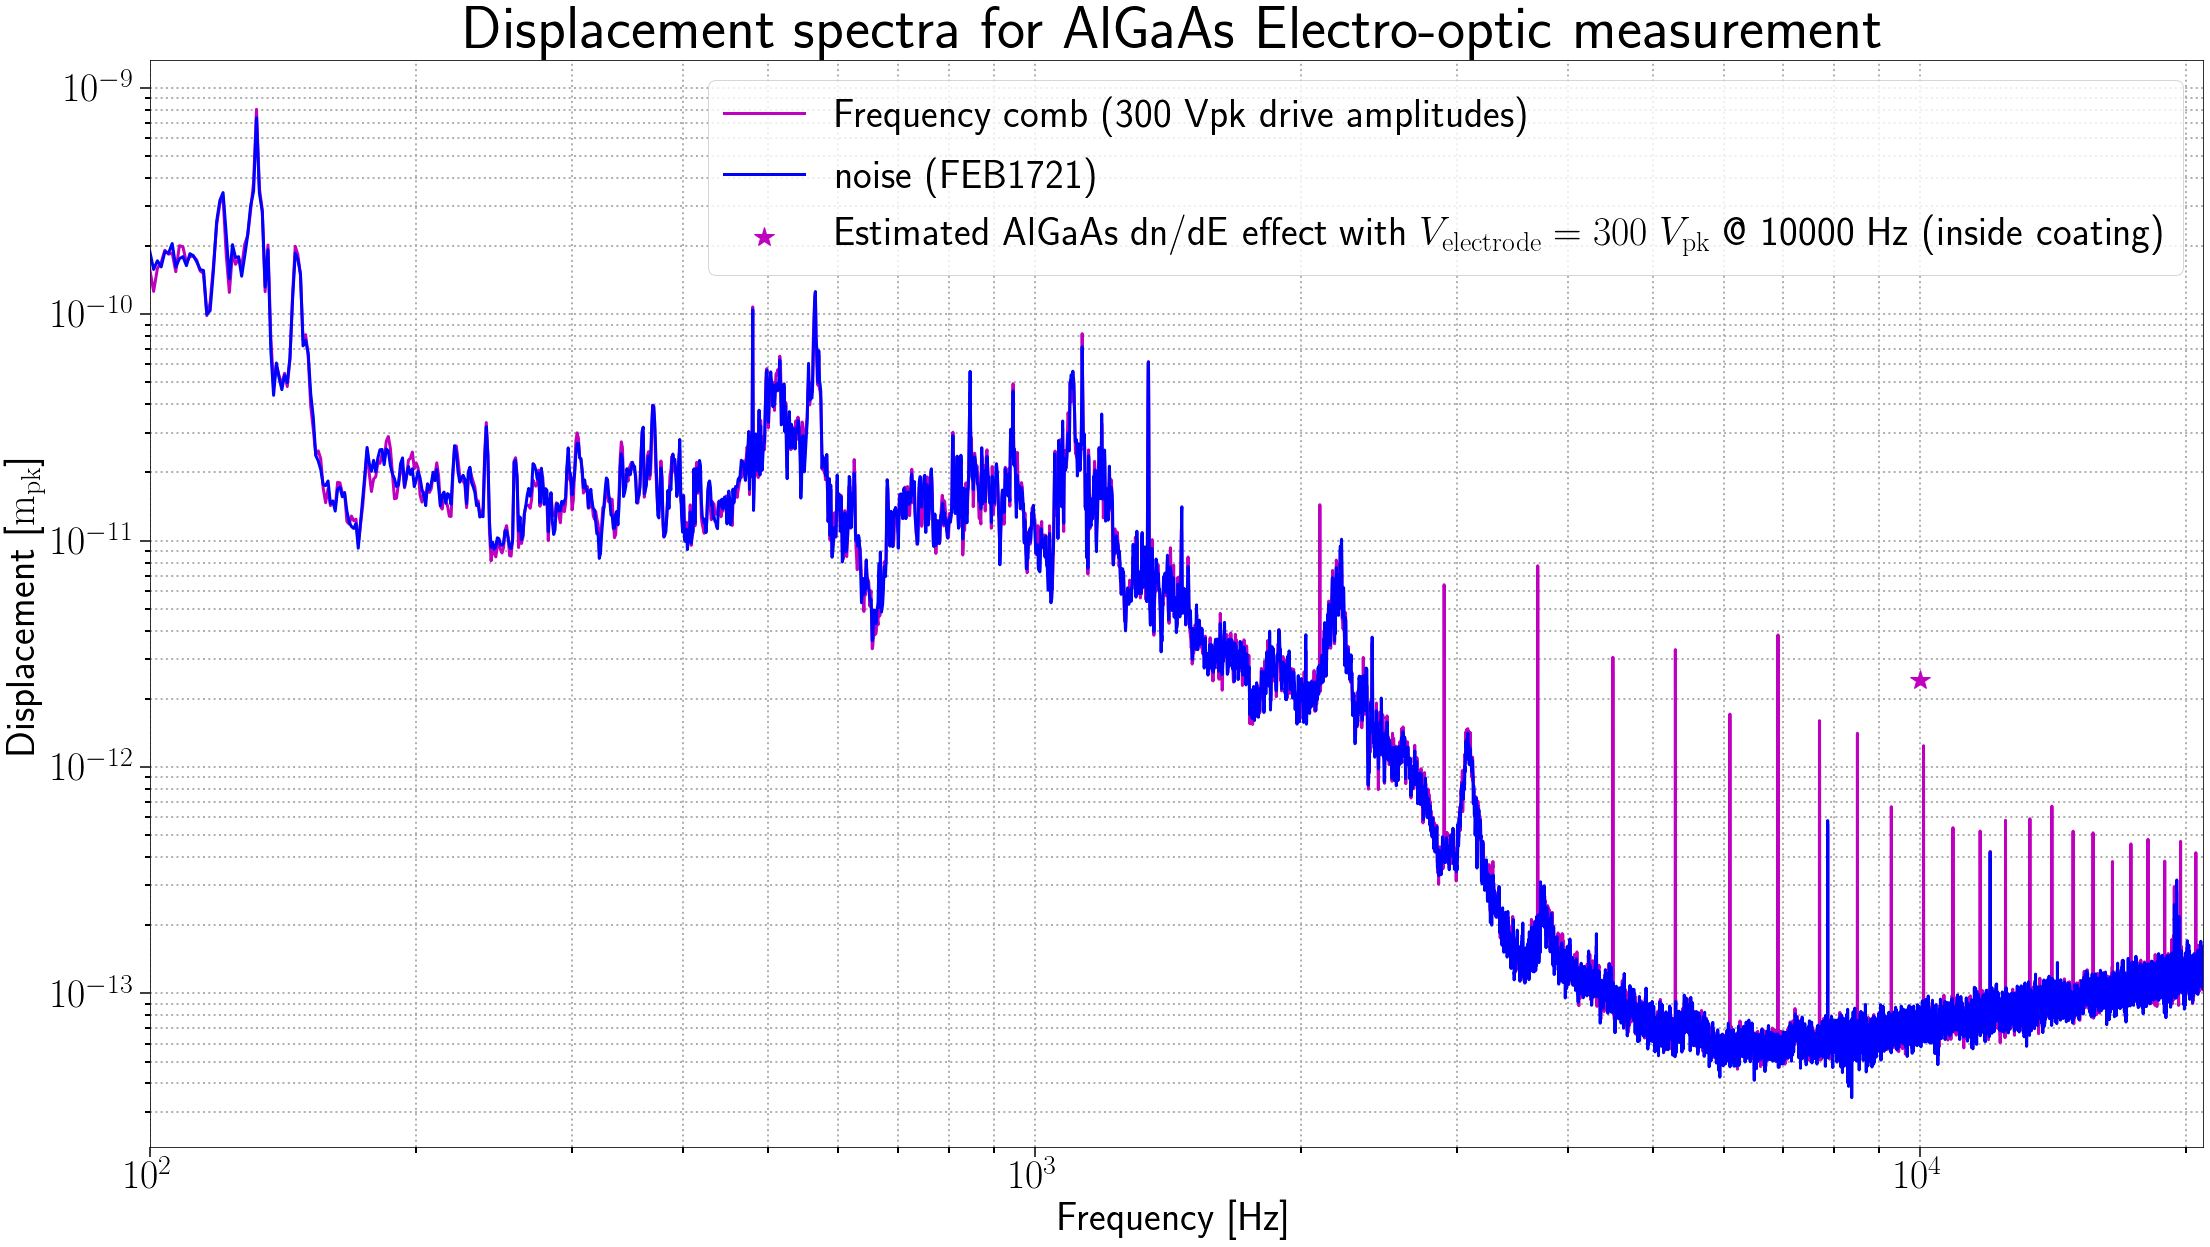

In [78]:
#plt.loglog(fff,dHz2*Lcav/nu, color='k',label='Electrodes driven [$V_\mathrm{electrode}= 300\; V_\mathrm{pk}$ @ 10000 Hz with AlGaAs coating] (FEB)', linewidth=3)
#plt.loglog(fff,nHz2*Lcav/nu, color = 'r', label='Noise (FEB)',linewidth=3)

#plt.loglog(fff,dHz1*Lcav/nu, color='g',label='Electrodes driven [$V_\mathrm{electrode}= 300\; V_\mathrm{pk}$ @ 10000 Hz with AlGaAs coating] (JAN)', linewidth=3)
#plt.loglog(fff,nHz1*Lcav/nu, color = 'b', label='Noise (JAN)',linewidth=3)

#plt.loglog(fff,dHz*Lcav/nu,color='r',label='Electrodes undriven with AlGaAs coating', linewidth=3)
#plt.loglog(np.array([10000,10000]),3.8e-16*np.array([2500.0,5000.0]), label = 'Estimated EO effect with $V_\mathrm{electrode}= 100 \;V$ and 100 sec integration time',linewidth=8)
plt.loglog(fff,swHz1*Lcav/nu,color='m',label='Frequency comb (300 Vpk drive amplitudes)', linewidth=3)
plt.loglog(fff,swnHz1*Lcav/nu,color='b',label='noise (FEB1721) ', linewidth=3)
plt.loglog(10000,3.8e-16*6350.0 ,'*',color='m', label='Estimated AlGaAs dn/dE effect with $V_\mathrm{electrode}= 300\; V_\mathrm{pk}$ @ 10000 Hz (inside coating)',markersize=20)
#plt.loglog(10000,nHz2[78]*Lcav/nu*10,'o',color='r', label='SNR=10',markersize=15)
plt.xlim([fff[0], fff[-1]])
plt.legend()
plt.xlabel('Frequency [Hz]')
plt.ylabel('Displacement [$\mathrm{m}_\mathrm{pk}$]')
plt.title("Displacement spectra for AlGaAs Electro-optic measurement")
#plt.savefig(folder + 'displacement_electrodes_driven_300V.png',dpi=300,bbox_inches='tight')

In [131]:
swHz1[0]*Lcav/nu

1.577969285573156e-10

In [132]:
u = swHz1[0]*Lcav/nu

In [133]:
u.type

AttributeError: 'numpy.float64' object has no attribute 'type'